In [244]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

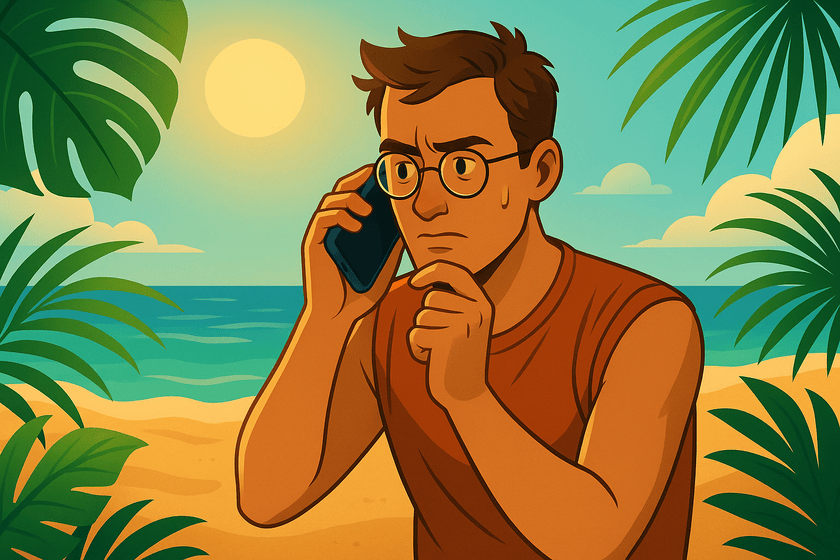

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [377]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [391]:
learning_data = titanic_df.copy()
learning_data.drop(columns=['Name', 'Ticket', 'Embarked'], axis=1, inplace=True) # usunięcie zbędnych kolumn

In [392]:
def get_percentage_missing(df, axis):
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

missing_cols_mi = get_percentage_missing(learning_data, axis=0) # sprawdzenie rozkładu NaNów
missing_cols_mi

,0
Age,19.87
Fare,11.00
Cabin,77.10


Powyższa tabela przedstawia procentowy udział wartości NaN z podziałem na kolumny. Na początku postanowiłem wypełnić puste komórki w kolumnie [Age], wykorzystując do tego rozkład tej zmiennej z niepustych komórek.

In [397]:
def get_column_distribution(df, column): # funkcja do wydobycia rozkładu
  return df[column].value_counts(normalize=True)

In [398]:
age_count_prob = get_column_distribution(learning_data, 'Age')

age_values = age_count_prob.index
age_probs = age_count_prob.values

missing_age_vals = learning_data.Age.isna()
# pozbycie się wartości NaN
learning_data.loc[missing_age_vals, 'Age'] = np.random.choice(age_values, size=missing_age_vals.sum(), p=age_probs)

missing_cols_mi = get_percentage_missing(learning_data, axis=0)
missing_cols_mi

,0
Fare,11.0
Cabin,77.1


Zanim usunąłbym wartości NaN z kolejnej kolumny [Fare], zauważyłem, że zawsze są one związane z pierwszą klasą, co pokazują wyniki poniżej.

In [400]:
learning_data[learning_data['Fare'].isna() & learning_data['Pclass'] == 1].shape[0]

83

In [401]:
learning_data[learning_data['Fare'].isna() & learning_data['Pclass'] == 2].shape[0]

0

In [402]:
learning_data[learning_data['Fare'].isna() & learning_data['Pclass'] == 3].shape[0]

0

Zdecydowałem się więc te wartości jakoś uzupełnić. Wcześniej sprawdziłem jednak rozkład tych danych...

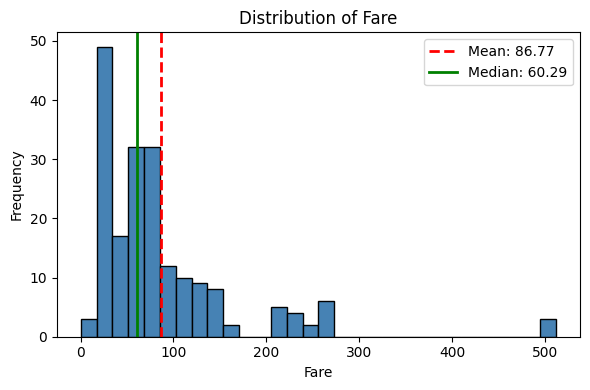

In [403]:
def plot_numeric_histogram(df, column_name):
    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_numeric_histogram(learning_data[learning_data['Pclass'] == 1], 'Fare')

... oraz ile w sumie jest osób z pierwszej klasy w bazie.

In [404]:
learning_data[learning_data['Pclass'] == 1].shape[0]

216

83 NaNy na 216 wierszy to nie jest aż tak mało, dlatego do wypełniania brakujących wartości wybrałem rozkład tej zmiennej z niepustych komórek, podobnie jak w przypadku kolumny [Age].

In [405]:
fare_count_prob = get_column_distribution(learning_data, 'Fare')

fare_values = fare_count_prob.index
fare_probs = fare_count_prob.values

missing_fare_vals = learning_data.Fare.isna()
learning_data.loc[missing_fare_vals, 'Fare'] = np.random.choice(fare_values, size=missing_fare_vals.sum(), p=fare_probs)

missing_cols_mi = get_percentage_missing(learning_data, axis=0)
missing_cols_mi

,0
Cabin,77.1


Następnie kolumnę [Cabin] podmieniłem na sam pokład [Deck], gdyż z powodu tak dużej liczby NaN trudno byłoby wypełnić pokoje.

In [406]:
learning_data['Deck'] = learning_data['Cabin'].dropna().astype(str).str[0]
learning_data.drop(columns=['Cabin'], axis=1, inplace=True)
learning_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,NaN
4,1,1,female,35.0,1,0,53.1000,C
5,0,3,male,35.0,0,0,8.0500,NaN


Do wypełnienia NaN z kolumny [Deck] wykorzystałem samodzielnie utworzony rozkład prawdopodobieństwa uzależniony od klasy pasażera, na podstawie załączonej grafiki.
![Sample Image](https://www.encyclopedia-titanica.org/files/1/figure-one-side-view.gif)

In [407]:
deck_values = learning_data.Deck.dropna().unique()
deck_values.sort()
# prawdopodobieństwo na pokład    A         B         C           D         E         F         G         T (Boat deck)
deck_probs_1st_class = pd.Series([1.0/11.0, 2.5/11.0, 3.25/11.0, 1.0/11.0, 3.25/11.0, 0.0,      0.0,      0.0])
deck_probs_2nd_class = pd.Series([0.0,      0.0,      0.0,       1.0/6.0,  3.0/6.0,   2.0/6.0,  0.0,      0.0])
deck_probs_3rd_class = pd.Series([0.0,      0.0,      0.0,       4.0/17.0, 3.0/17.0,  6.0/17.0, 4.0/17.0, 0.0])

missing_deck_1st_class_vals = learning_data[learning_data['Pclass'] == 1].Deck.isna()
missing_deck_2nd_class_vals = learning_data[learning_data['Pclass'] == 2].Deck.isna()
missing_deck_3rd_class_vals = learning_data[learning_data['Pclass'] == 3].Deck.isna()

learning_data.loc[(learning_data['Pclass'] == 1) & missing_deck_1st_class_vals, 'Deck'] = np.random.choice(deck_values, size=missing_deck_1st_class_vals.sum(), p=deck_probs_1st_class)
learning_data.loc[(learning_data['Pclass'] == 2) & missing_deck_2nd_class_vals, 'Deck'] = np.random.choice(deck_values, size=missing_deck_2nd_class_vals.sum(), p=deck_probs_2nd_class)
learning_data.loc[(learning_data['Pclass'] == 3) & missing_deck_3rd_class_vals, 'Deck'] = np.random.choice(deck_values, size=missing_deck_3rd_class_vals.sum(), p=deck_probs_3rd_class)

missing_cols_mi = get_percentage_missing(learning_data, axis=0)
missing_cols_mi

,0


In [408]:
learning_data.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Deck,object


Po pozbyciu się NaNów oraz sprawdzeniu typów danych, przystąpiłem do kodowania cech kategorialnych jak poniżej...

In [409]:
learning_data['Is_child'] = np.where(learning_data['Age'] < 13, 1, 0)
learning_data['Sex'] = learning_data.Sex.map({'male': 1, 'female': 0})
learning_data['Deck'] = learning_data.Deck.map({
    'G': 0, 'F': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6, 'T': 7
})

...i w ten sposób uzyskałem tabelę do nauki modelu.

In [410]:
learning_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Is_child
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0
2,1,1,0,38.0,1,0,71.2833,4,0
3,1,3,0,26.0,0,0,7.9250,0,0
4,1,1,0,35.0,1,0,53.1000,4,0
5,0,3,1,35.0,0,0,8.0500,0,0


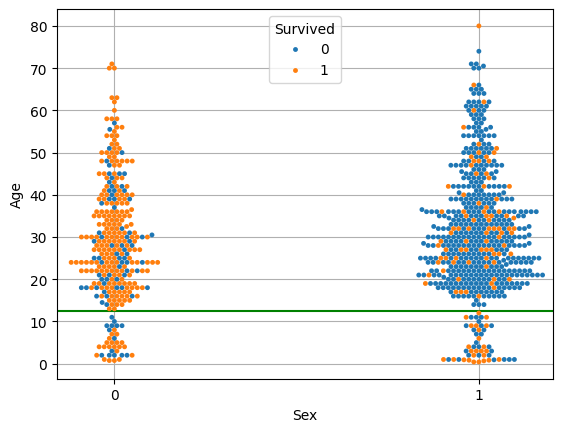

In [471]:
def swarm_plot(df, x, y, hue=None, size=3.5):
    sns.swarmplot(data=learning_data, x=x, y=y, hue=hue, size=size)
    plt.grid(True)
    plt.plot()

plt.axhline(y=12.5, color='g', linestyle='-')
swarm_plot(learning_data, 'Sex', 'Age', 'Survived')

Na powyższej grafice przedstawiony został rozkład wiekowy pasażerów z podziałem na płeć. Ponadto kolorem pomarańczowym wyszczególnione zostało kto przeżył. Zauważyć można tutaj wpływ zasady "najpierw kobiety i dzieci", która obowiązywała podczas ewakuacji pasażerów. Granicę pomiędzy dziećmi a dorosłymi wyznacza zielona pozioma linia y=12.5, gdyż w tamtym czasie jako dziecko najczęściej uznawano osoby niezdolne do pracy (poniżej 13 roku życia).
Source: https://www.reddit.com/r/titanic/comments/15snc0r/what_age_was_a_boy_no_longer_considered_a_child/

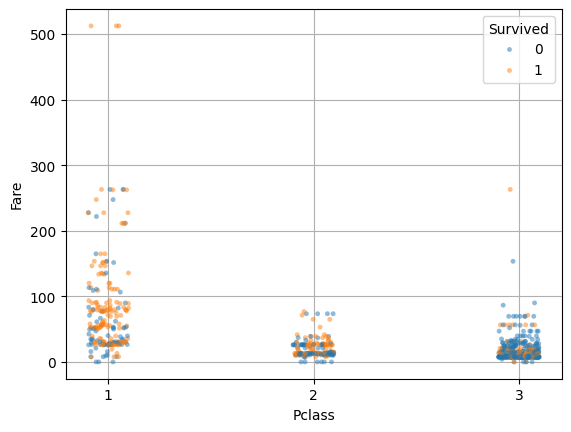

In [454]:
def strip_plot(df, x, y, hue=None, size=3.5):
    sns.stripplot(data=learning_data, x=x, y=y, hue=hue, size=size, alpha=0.5)
    plt.grid(True)
    plt.plot()

strip_plot(learning_data, 'Pclass', 'Fare', 'Survived')

Następna grafika przedstawia wpływ klasy pasażera oraz ceny biletu na to kto przeżył katastrofę. O ile wybór droższego biletu w obrębie pojedynczej klasy nie zdaje się mieć wpływu, tak biorąc pod uwagę wszystkie klasy, cena biletu wykazuje umiarkowaną korelację z możliwością przeżycia, spowodowaną rosnącymi cenami wraz z coraz lepszymi klasami. Dodatkowo same klasy wykazują dość istotny wpływ, zwiększając szanse przeżycia wraz z lepszą klasą.

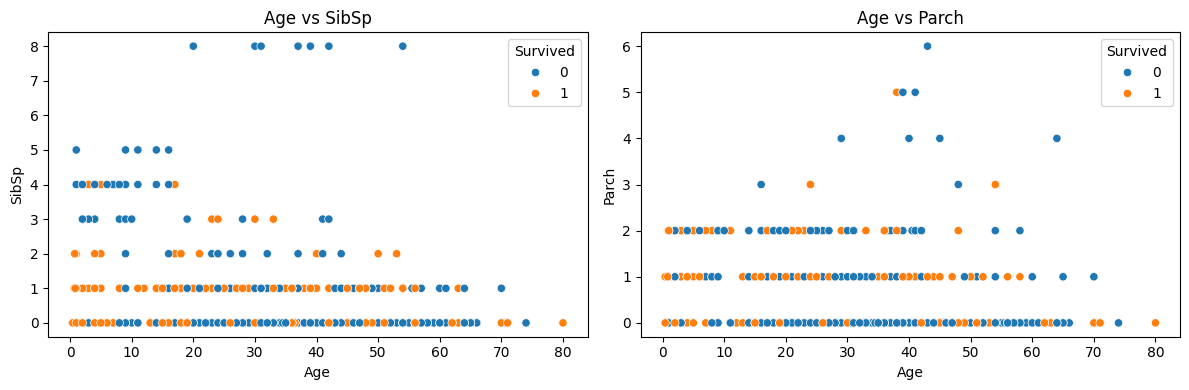

In [469]:
def scatter_plot(df, x, y, hue=None, plot_nr=1):
    plt.subplot(1, 2, plot_nr)
    sns.scatterplot(data=df, x=x, y=y, color='darkorange', hue=hue)
    plt.title(f'{x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)

plt.figure(figsize=(12, 4))
scatter_plot(learning_data, 'Age', 'SibSp', hue='Survived', plot_nr=1)
scatter_plot(learning_data, 'Age', 'Parch', hue='Survived', plot_nr=2)
plt.tight_layout()
plt.show()

Kolejna grafika przedstawia szanse przeżycia uzależnione od wskaźników SibSp (rodzeństwo i małżonkowie) oraz Parch (rodzice i potomstwo). Zdecydowanie większy wpływ zdaje się mieć wskaźnik SibSp. Wartość powyżej 4 prawie zawsze oznaczała śmierć pasażera, podczas gdy dla mniejszej niż 2 oznaczała dość duże szanse na przeżycie. Może to być spowodowane tym, że w przypadku zagubienia się osoby bliskiej, pozostałe osoby były bardziej skłonne do jej poszukiwania, zamiast do ewakuacji. <br>
Wskaźnik Parch natomiast nie wykazuje tak silnej zależności, lecz problematyczny jest tu również brak większej liczby danych dla wskaźnika o wartośći powyżej 2.

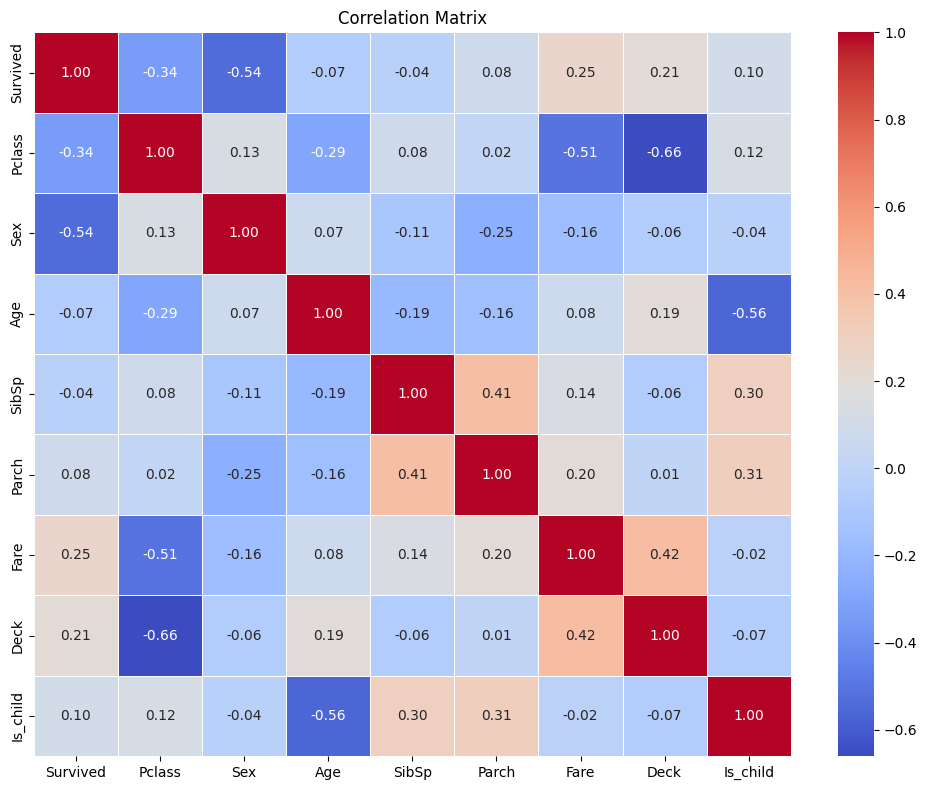

In [444]:
def plot_correlation_matrix(df):
    corr = df.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(learning_data)

Na koniec prezentuję podsumowanie w postaci macierzy. Zauważyć tu można podobne obserwacje, co na prezentowanych wcześniej wykresach m.in. silny wpływ płci oraz klasy pasażera na wskaźnik Survived. Dodatkowo dostrzec można dość silną korelację pomiędzy wskaźnikami SibSp i Parch oraz pokładem, na którym pasażer się znajdował z ceną biletu.